## AdaBoost



### 习题8.1
&emsp;&emsp;某公司招聘职员考查身体、业务能力、发展潜力这3项。身体分为合格1、不合格0两级，业务能力和发展潜力分为上1、中2、下3三级分类为合格1 、不合格-1两类。已知10个人的数据，如下表所示。假设弱分类器为决策树桩。试用AdaBoost算法学习一个强分类器。  

应聘人员情况数据表

&emsp;&emsp;|1|2|3|4|5|6|7|8|9|10
-|-|-|-|-|-|-|-|-|-|-
身体|0|0|1|1|1|0|1|1|1|0
业务|1|3|2|1|2|1|1|1|3|2
潜力|3|1|2|3|3|2|2|1|1|1
分类|-1|-1|-1|-1|-1|-1|1|1|-1|-1



In [66]:
import numpy as np

# 加载训练数据
X = np.array([[0, 1, 3], [0, 3, 1], [1, 2, 2], [1, 1, 3], [1, 2, 3], [0, 1, 2],
              [1, 1, 2], [1, 1, 1], [1, 3, 1], [0, 2, 1]])
y = np.array([-1, -1, -1, -1, -1, -1, 1, 1, -1, -1])

**AdaBoostClassifier分类器实现：**

采用sklearn的AdaBoostClassifier分类器直接求解，由于AdaBoostClassifier分类器默认采用CART决策树弱分类器，故不需要设置base_estimator参数。

In [67]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier()
clf.fit(X, y)
y_predict = clf.predict(X)
score = clf.score(X, y)
print("原始输出:", y)
print("预测输出:", y_predict)
print("预测正确率：{:.2%}".format(score))

原始输出: [-1 -1 -1 -1 -1 -1  1  1 -1 -1]
预测输出: [-1 -1 -1 -1 -1 -1  1  1 -1 -1]
预测正确率：100.00%


###  实现 AdaBoost 的二分类

In [ ]:
class AdaBoost:
    """
    完成 二分类 

    基分类器为 决策树桩 (stump)


    """

    def __init__(self, error_rate_threshold =0.05, max_iter=10):

        # 训练中止条件 error_rate <self.error_rate_threshold ( 若当前得到的基分类器的组合 错误率 小于阈值, 则停止训练)
        self.error_rate_threshold = error_rate_threshold

        # 最大迭代次数
        self.max_iter = max_iter

        self.G = []  # 弱分类器

    def build_stump(self, X, y, w):
        """
        以带权重的分类误差最小为目标，选择最佳 分类特征 和 分类特征的阈值

        best_stump['feature'] 合适的特征所在维度
        best_stump['value']  合适特征的阈值
        best_stump['flag']  树桩分类的标识lt,rt

        """

        best_stump = {}

        feature_Num = np.shape(X)[1]  # 特征的数目

        N = np.shape(X)[0]  # 样本的个数

        min_em = float('inf')  # 最小的 分类误差率

        min_em_y_predict = None  # 最小分类误差率 对应的 y 的预测值

        for feature in range(feature_Num):  # 遍历 所有特征

            feature_value_set = {v for v in X[:, feature]}

            for value in feature_value_set:  # 遍历特征的所有取值

                for flag in ['lt', 'rt']:  # 树桩的分类 标识,
                    #  若为 'lt' , 则 左边( <= ) 为负例 -1, 右边( > )为正例 +1
                    #  若为 'rt' , 则 左边( <= ) 为正例 +1, 右边( > )为 负例 -1

                    y_predict = self.base_estimator(X[:, feature], value, flag)

                    err_arr = np.ones(N, dtype=int)
                    err_arr[y_predict == y] = 0  # y_predict 与 y 相等为0, 不等为1

                    em = np.dot(w, err_arr)  # 公式 8.1 ; 加权的分类误差率 ( 样本权重的作用 )

                    if em < min_em: z # 找到分类误差率 最小的 决策树 
                        min_em = em
                        min_em_y_predict = y_predict
                        best_stump['feature'] = feature
                        best_stump['value'] = value
                        best_stump['flag'] = flag

        return min_em, min_em_y_predict, best_stump

    def updata_w(self, y, w, y_predict, alpha):
        """
        更新样本权重w
        """
        # 根据公式8.4 8.5 更新样本权重

        p_arr = w * np.exp(-alpha * y_predict * y)

        zm = np.sum(p_arr)

        w = p_arr / zm

        return w

    def base_estimator(self, X_feature, value, flag):
        """
        计算单个弱分类器（决策树桩）预测输出
        """
        y_predict = np.zeros(len(X_feature), dtype=int)

        if flag == 'lt':

            y_predict[X_feature <= value] = -1
            y_predict[X_feature > value] = 1

        else:  # flag == 'rt':

            y_predict[X_feature <= value] = 1
            y_predict[X_feature > value] = -1

        return y_predict

    def fit(self, X, y):

        """
        对训练数据进行学习
        """
        N = np.shape(X)[0]

        # 初始化样本权重w
        w = np.ones((N)) * (1 / N)

        f = 0  # 最终分类器

        for m in range(self.max_iter):  # 进行 第 m 轮迭代

            em, y_predict, best_stump = self.build_stump(X, y, w)

            alpha = (1 / 2) * np.log((1 - em) / em)

            self.G.append((alpha, best_stump))  # 存储 基分类器

            # 当前 所有弱分类器加权 得到的 最终分类器 的 分类错误率

            f += alpha * y_predict
            G = np.sign(f)

            err_arr = np.ones(N, dtype=int)
            err_arr[G == y] = 0
            err_rate = np.mean(err_arr)

            print('round:{}, err_rate:{}'.format(m, err_rate))

            if err_rate < self.error_rate_threshold:  # 错误率 已经小于 阈值, 则停止训练
                break

                # 更新 w
            w = self.updata_w(y, w, y_predict, alpha)

    def predict(self, X):
        """
        对新数据进行预测

        """

        f = 0  # 最终分类器

        for alpha, best_stump in self.G:
            y_predict = self.base_estimator(X[:, best_stump['feature']], best_stump['value'], best_stump['flag'])

            f += alpha * y_predict

        G = np.sign(f)

        return G.astype(int)

    def score(self, X, y):
        """对训练效果进行评价"""

        G = self.predict(X)

        N = np.shape(X)[0]  # 样本的个数

        err_arr = np.ones(N, dtype=int)
        err_arr[G == y] = 0
        err_rate = np.mean(err_arr)

        accuracy = 1 - err_rate

        return accuracy

In [ ]:
clf = AdaBoost()
clf.fit(X,y)

print(clf.G)

y_predict = clf.predict(X)
score = clf.score(X, y)

print("原始输出:", y)
print("预测输出:", y_predict)
print("预测正确率：{:.2%}".format(score))

In [ ]:
def loadData( fileName, n=1000):
    '''
    加载文件
    :param fileName:要加载的文件路径
    :param n: 返回的数据集的规模
    :return: 数据集和标签集
    '''
    # 存放数据及标记
    dataArr = []
    labelArr = []
    # 读取文件
    fr = open(fileName)

    cnt = 0  # 计数器

    # 遍历文件中的每一行
    for line in fr.readlines():

        if cnt == n:
            break

        # 获取当前行，并按“，”切割成字段放入列表中
        # strip：去掉每行字符串首尾指定的字符（默认空格或换行符）
        # split：按照指定的字符将字符串切割成每个字段，返回列表形式
        curLine = line.strip().split(',')
        # 将每行中除标记外的数据放入数据集中（curLine[0]为标记信息）
        # 在放入的同时将原先字符串形式的数据转换为整型
        # 此外将数据进行了二值化处理，大于128的转换成1，小于的转换成0，方便后续计算
        dataArr.append([int(int(num) > 128) for num in curLine[1:]])


        # 将标记信息放入标记集中
        # 转换成二分类任务
        # 标签0设置为1，反之为-1
        if int(curLine[0]) == 0:
            labelArr.append(1)
        else:
            labelArr.append(-1)

        cnt += 1

    fr.close()

    # 返回数据集和标记
    return dataArr, labelArr

In [ ]:
n_train=60000
n_test=10000


# 获取训练集
trainDataList, trainLabelList = loadData('../Mnist/mnist_train.csv', n=n_train)

print('train data, row num:{} , column num:{} '.format(len(trainDataList), len(trainDataList[0])))

trainDataArr = np.array(trainDataList)
trainLabelArr = np.array(trainLabelList)

In [ ]:
import time 

# 开始时间
print('start training model....')
start = time.time()

clf = AdaBoost(error_rate_threshold=0.02, max_iter=40)
clf.fit(trainDataArr, trainLabelArr)

print(clf.G)

# 结束时间
end = time.time()
print('training cost time :', end - start)

In [ ]:
# 获取测试集
testDataList, testLabelList = loadData('../Mnist/mnist_test.csv', n=n_test)

print('test data, row num:{} , column num:{} '.format(len(testDataList), len(testDataList[0])))

testDataArr = np.array(testDataList)
testLabelArr = np.array(testLabelList)

print('test dataset accuracy: {} '.format(clf.score(testDataArr, testLabelArr)) )

### sklearn 的 AdaBoost 多分类 实现

**sklearn AdaBoostClassifier 的 二分类实现:**

In [ ]:
# sklearn AdaBoostClassifier 

from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier()
clf.fit(trainDataArr, trainLabelArr)


score = clf.score(testDataArr, testLabelArr)

print("测试集 正确率：{:.2%}".format(score))

**sklearn AdaBoostClassifier 的多分类实现:**

In [ ]:
import numpy as np

# sklearn AdaBoostClassifier 的 多分类

def loadData( fileName, n=1000):
    '''
    加载文件
    :param fileName:要加载的文件路径
    :param n: 返回的数据集的规模
    :return: 数据集和标签集
    '''
    # 存放数据及标记
    dataArr = []
    labelArr = []
    # 读取文件
    fr = open(fileName)

    cnt = 0  # 计数器

    # 遍历文件中的每一行
    for line in fr.readlines():

        if cnt == n:
            break

        # 获取当前行，并按“，”切割成字段放入列表中
        # strip：去掉每行字符串首尾指定的字符（默认空格或换行符）
        # split：按照指定的字符将字符串切割成每个字段，返回列表形式
        curLine = line.strip().split(',')
        # 将每行中除标记外的数据放入数据集中（curLine[0]为标记信息）
        # 在放入的同时将原先字符串形式的数据转换为整型
        # 此外将数据进行了二值化处理，大于128的转换成1，小于的转换成0，方便后续计算
        dataArr.append([int(int(num) > 128) for num in curLine[1:]])


        # 将标记信息放入标记集中
        labelArr.append(int(curLine[0]))
        cnt += 1

    fr.close()

    # 返回数据集和标记
    return dataArr, labelArr

In [ ]:
n_train=60000
n_test=10000


# 获取训练集
trainDataList, trainLabelList = loadData('../Mnist/mnist_train.csv', n=n_train)

print('train data, row num:{} , column num:{} '.format(len(trainDataList), len(trainDataList[0])))

trainDataArr = np.array(trainDataList)
trainLabelArr = np.array(trainLabelList)

In [ ]:
# 获取测试集
testDataList, testLabelList = loadData('../Mnist/mnist_test.csv', n=n_test)

print('test data, row num:{} , column num:{} '.format(len(testDataList), len(testDataList[0])))

testDataArr = np.array(testDataList)
testLabelArr = np.array(testLabelList)

In [ ]:
'''
AdaBoostClassifier参数解释
base_estimator:弱分类器，默认是CART分类树：DecisionTressClassifier

algorithm：在scikit-learn实现了两种AdaBoost分类算法，即SAMME和SAMME.R，
           SAMME就是原理篇介绍到的AdaBoost算法，指Discrete AdaBoost
           
           SAMME.R指Real AdaBoost，返回值不再是离散的类型，而是一个表示概率的实数值，算法流程见后文
           两者的主要区别是弱分类器权重的度量，SAMME使用了分类效果作为弱分类器权重，SAMME.R使用了预测概率作为弱分类器权重。
           SAMME.R的迭代一般比SAMME快，默认算法是SAMME.R。因此，base_estimator必须使用支持概率预测的分类器。

loss：这个只在回归中用到，不解释了
n_estimator:最大迭代次数，默认50。在实际调参过程中，常常将n_estimator和学习率learning_rate一起考虑

learning_rate:每个弱分类器的权重缩减系数v。f_k(x)=f_{k-1}*a_k*G_k(x)。较小的v意味着更多的迭代次数，默认是1，也就是v不发挥作用。
另外的弱分类器的调参，弱分类器不同则参数不同，这里不详细叙述

'''

In [ ]:
# sklearn AdaBoostClassifier 

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5)
                        ,algorithm="SAMME",n_estimators=25, learning_rate=0.8)


clf.fit(trainDataArr, trainLabelArr)


score = clf.score(testDataArr, testLabelArr)

print("测试集 正确率：{:.2%}".format(score))  #  90.59%: SAMME.R ,max_depth=5 ,n_estimators=100 ,learning_rate=0.8
                                              #  87.19%: SAMME ,max_depth=5 ,n_estimators=25 ,learning_rate=0.8

#### 关键问题：AdaBoost 每次迭代 改变的样本权重是如何 带入到 基分类器 (eg.决策树) 的 训练中的


样本权重会影响 基尼指数的计算，进而影响节点的划分和决策树的构造

样本权值，本质上是样本的数量分布。要影响到弱分类器 ，分两种情况:

1. 通过修改弱分类器代码，使它支持带权值的训练样本。不同弱分类器修改方法也不同，一般需要修改损失函数，拿LR来说，如果原来的损失函数是cost(x)，那么现在应该是w*cost(x)，w是样本权值，对于树模型，则需要修改信息增益或者gini的公式，引入权值 。

2. 如果不方便修改分类器代码，那么可以对训练样本，进行bootstrap抽样，每次抽样的概率等于样本权值 ，这样可以达到类似效果，不过不如第一种方法直接。


adaboost，使用LR或者SVM这样的线性强分类器，可能造成两个问题:

1. 第一次产生的分类器错误率上已经达到极限，使后面的分类器起不到效果，或者说分类器的差异性太小
2. 训练出来的多个分类器，基本是相似位置的超平面 ，也就是说，最后组合得到的，还是一个线性分类器，因此模型对数据的拟合能力，不如非线性分类器，达不到adaboost组合变强的效果

ref:
https://stackoverflow.com/questions/34389624/what-does-sample-weight-do-to-the-way-a-decisiontreeclassifier-works-in-skle

[ 0.5 -2.  -2. ]
[0.44444444 0.         0.5       ]
                                       0 -> 0.5
                                      -2 -> -2.0
                                      -2 -> -2.0


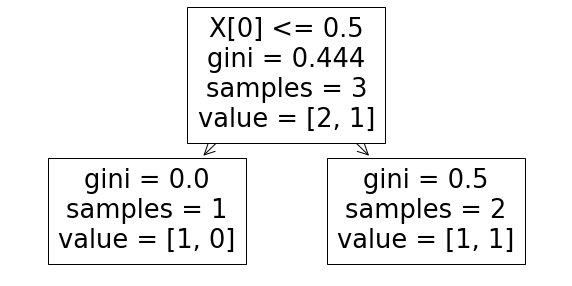

In [26]:
from sklearn.tree import DecisionTreeClassifier , plot_tree

X = [[0],
     [1],
     [2]] # 3 simple training examples

Y = [ 1,  2,  1 ] # class labels

X=np.array(X)
Y = np.array(Y)

dtc = DecisionTreeClassifier(max_depth=1,criterion="gini", splitter='best')

dtc.fit(X,Y)

print (dtc.tree_.threshold) # threshold 为划分的 阈值
# [0.5, -2, -2]
print (dtc.tree_.impurity) #  impurity 为 各个节点的基尼不纯度
# [0.44444444, 0, 0.5]
# values 为 该节点中 不同分类的样本 个数


for name, val in zip(dtc.tree_.feature, dtc.tree_.threshold):
    print(f"{name:>40} -> {val}")

plt.figure(figsize=(10, 5))
plot_tree(dtc) 
plt.show()

In [19]:
from CartTree_classification_xrh import *

CT = CartTree(max_depth=1)

CT.fit(X,Y)

T.feature:None,T.feature_value:None, T.gini:0.0 
T.prev_feature:0,T.prev_feature_value:1-Yes 
T.childs:None
Tree depth:1
T.label:2
-----------
T.feature:None,T.feature_value:None, T.gini:0.0 
T.prev_feature:0,T.prev_feature_value:1-No 
T.childs:None
Tree depth:1
T.label:1
-----------
T.feature:0,T.feature_value:1, T.gini:0.4444444444444444 
T.prev_feature:None,T.prev_feature_value:None 
T.childs:{0: <CartTree_classification_xrh.Node object at 0x000001F508081320>, 1: <CartTree_classification_xrh.Node object at 0x000001F503BD63C8>}
Tree depth:0
T.label:None
-----------


**计算基尼指数:**

1.对于 父节点:

p = Pr(Class=1) = 2 / 3  一共有 3 个样本( samples=3 ), 

value=[2,1] 样本的权重都为 1 ,类型1样本有2个, 总价值为2， 类型2 的样本 有1个, 总价值为 1  

gini = 2*(2.0/3.0)*(1.0/3.0) = 4/9 =0.444

[ 1.5 -2.  -2. ]
[0.46280992 0.44444444 0.        ]
                                       0 -> 1.5
                                      -2 -> -2.0
                                      -2 -> -2.0


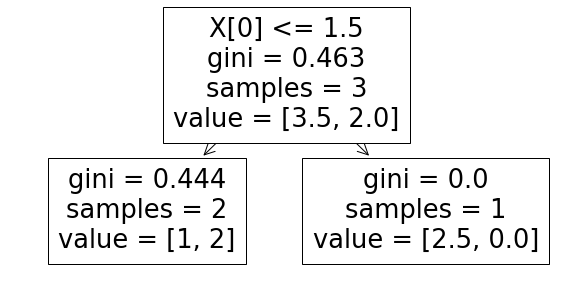

In [46]:
# 样本 权重会改变 基尼指数的计算, 进而改变 节点的划分

X = [[0],[1],[2]] # 3 simple training examples
Y = [ 1,  2,  1 ] # class labels

X=np.array(X)
Y = np.array(Y)

sample_weight=np.array([1,2,2.5])

dtc.fit(X,Y,sample_weight=sample_weight)
print (dtc.tree_.threshold)
# [1.5, -2, -2]
print (dtc.tree_.impurity)
# [0.44444444, 0.44444444, 0.]

 # value 为 该节点中 不同 分类的 样本 总分值

for name, val in zip(dtc.tree_.feature, dtc.tree_.threshold):
    print(f"{name:>40} -> {val}")

plt.figure(figsize=(10, 5))
plot_tree(dtc) 
plt.show()

**计算基尼指数:**

1.对于 父节点:

它含有 两种类型的样本, 各个样本的权重分别为 [1,2,3]

p = Pr(Class=1) = (1+3) / (1+2+3) = 2.0/3.0  将样本的权重 考虑进来 ,

value=[4,2] : 类型为1 的样本有2个, 他们的权重分别为 [1,3], 总价值为 4 ; 类型为2 的样本有1个, 它的权重为 2，总价值为 2



gini = 2*(2.0/3.0)*(1.0/3.0) = 4/9 =0.444


2.对于左子节点

p = Pr(Class=1) = 1 / (1+2)  = 1/3

gini = 2*(1.0/3.0)*(2.0/3.0) = 4/9 =0.444


2.对于 右子节点

p = Pr(Class=1) = 3 / (3+0)  = 1 

gini=0

In [47]:
CT = CartTree(max_depth=1)

sample_weight=np.array([1,2,2.5])

CT.fit(X,Y,sample_weight=sample_weight)

T.feature:None,T.feature_value:None, T.gini:0.0 
T.prev_feature:0,T.prev_feature_value:1-Yes 
T.childs:None
Tree depth:1
T.label:2
-----------
T.feature:None,T.feature_value:None, T.gini:0.0 
T.prev_feature:0,T.prev_feature_value:1-No 
T.childs:None
Tree depth:1
T.label:1
-----------
T.feature:0,T.feature_value:1, T.gini:0.4628099173553719 
T.prev_feature:None,T.prev_feature_value:None 
T.childs:{0: <CartTree_classification_xrh.Node object at 0x000000000EFBDD60>, 1: <CartTree_classification_xrh.Node object at 0x000000000EFCEFD0>}
Tree depth:0
T.label:None
-----------


                                 alcohol -> 0.04727507393151268
                              malic_acid -> 0.0
                                     ash -> 0.0
                       alcalinity_of_ash -> 0.0
                               magnesium -> 0.0329784450464887
                           total_phenols -> 0.0
                              flavanoids -> 0.1414466773122087
                    nonflavanoid_phenols -> 0.0
                         proanthocyanins -> 0.0
                         color_intensity -> 0.0
                                     hue -> 0.08378677906228588
            od280/od315_of_diluted_wines -> 0.3120425747831769
                                 proline -> 0.38247044986432716

                                      12 -> 755.0
                                      11 -> 2.1149998903274536
                                      10 -> 0.9350000023841858
                                       6 -> 1.5800000429153442
                                      -2 ->

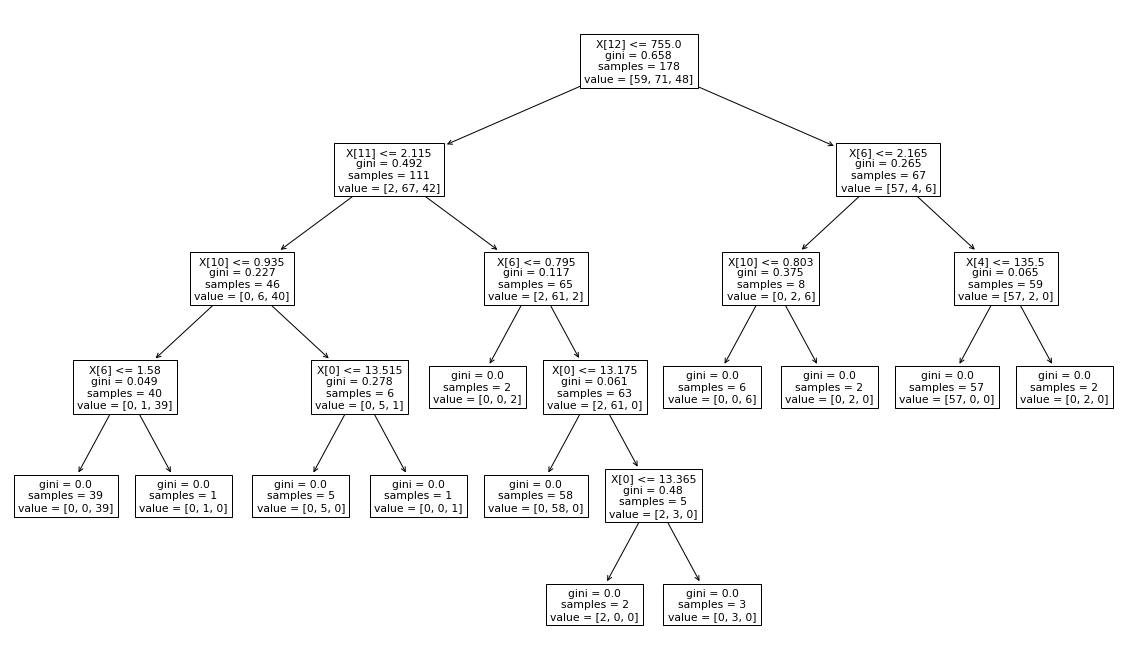

In [31]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree
import numpy as np
import matplotlib.pyplot as plt

wine = datasets.load_wine()

# Feature importance

clf = DecisionTreeClassifier(criterion="gini", splitter='best')
clf = clf.fit(wine.data, wine.target)

for name, val in zip(wine.feature_names, clf.feature_importances_):
    print(f"{name:>40} -> {val}")

print("")

for name, val in zip(clf.tree_.feature, clf.tree_.threshold):
    print(f"{name:>40} -> {val}")


# plot model
plt.figure(figsize=(20, 12))
plot_tree(clf) 
plt.show()

In [14]:
np.shape(wine.data)

(178, 13)

In [58]:
datasets = [['青年', '否', '否', '一般', '否'],
            ['青年', '否', '否', '好', '否'],
            ['青年', '是', '否', '好', '是'],
            ['青年', '是', '是', '一般', '是'],
            ['青年', '否', '否', '一般', '否'],
            ['中年', '否', '否', '一般', '否'],
            ['中年', '否', '否', '好', '否'],
            ['中年', '是', '是', '好', '是'],
            ['中年', '否', '是', '非常好', '是'],
            ['中年', '否', '是', '非常好', '是'],
            ['老年', '否', '是', '非常好', '是'],
            ['老年', '否', '是', '好', '是'],
            ['老年', '是', '否', '好', '是'],
            ['老年', '是', '否', '非常好', '是'],
            ['老年', '否', '否', '一般', '否'],
            ]


class PreProcess:
    """

    数据集的 预处理

    """

    @staticmethod
    def ordinal_encoding(dataset):
        """
        序号编码

        将类别型特征 转换为 数值型特征

        :param dataset:
        :return:
        """

        N, feature_Num = np.shape(dataset)

        features_idx_category_dic=[]

        for i in range(feature_Num):

            feature_i_category_set = {ele for ele in dataset[:, i]}  # 第i 个特征的 类别集合

            feature_i_idx_category_dic = {}

            for category, idx in zip(feature_i_category_set, range(len(feature_i_category_set))):
                feature_i_idx_category_dic[category] = idx

            features_idx_category_dic.append( feature_i_idx_category_dic ) # 存储 所有 类别型特征 和 转换后的数值型特征的对应关系

            dataset[:, i] = list(map(lambda x: feature_i_idx_category_dic[x], dataset[:, i]))

        return dataset,features_idx_category_dic

    

datasets= np.array(datasets)

dataset,features_idx_category_dic=PreProcess.ordinal_encoding(datasets)

print(datasets)

print(features_idx_category_dic)

[['1' '1' '1' '1' '1']
 ['1' '1' '1' '2' '1']
 ['1' '0' '1' '2' '0']
 ['1' '0' '0' '1' '0']
 ['1' '1' '1' '1' '1']
 ['0' '1' '1' '1' '1']
 ['0' '1' '1' '2' '1']
 ['0' '0' '0' '2' '0']
 ['0' '1' '0' '0' '0']
 ['0' '1' '0' '0' '0']
 ['2' '1' '0' '0' '0']
 ['2' '1' '0' '2' '0']
 ['2' '0' '1' '2' '0']
 ['2' '0' '1' '0' '0']
 ['2' '1' '1' '1' '1']]
[{'中年': 0, '青年': 1, '老年': 2}, {'是': 0, '否': 1}, {'是': 0, '否': 1}, {'非常好': 0, '一般': 1, '好': 2}, {'是': 0, '否': 1}]


In [61]:
from collections import Counter


Counter(y).most_common(1)[0][0]

0

In [65]:
dict={'a':1,'b':2}

max( dict.items() , key=lambda ele: ele[1]  )[0]

'b'

#### 关键问题：如何 利用 softmax 实现多分类器

**使用SAMME 的 AdaBoost 多分类**

ref: https://blog.csdn.net/kalath_aiur/article/details/105234675

In [49]:
import numpy as np

from sklearn import datasets

from sklearn.model_selection import train_test_split

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree

# 使用iris数据集，其中有三个分类， y的取值为0,1，2

iris= datasets.load_iris()  # 包括150行记录

X,y= iris.data,iris.target

# 将数据集一分为二，训练数据占80%，测试数据占20%
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 1024)

In [6]:
np.shape(X_train)

(120, 4)

In [50]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=3,algorithm='SAMME',learning_rate=1.0)
ada.fit(X_train,y_train)
learning_rate = 1.0
num = 3

In [51]:
ada.score(X_test,y_test)

0.9666666666666667

[Text(167.4, 163.07999999999998, 'X[2] <= 2.6\ngini = 0.666\nsamples = 120\nvalue = [0.325, 0.35, 0.325]'),
 Text(83.7, 54.360000000000014, 'gini = 0.0\nsamples = 39\nvalue = [0.325, 0.0, 0.0]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.499\nsamples = 81\nvalue = [0.0, 0.35, 0.325]')]

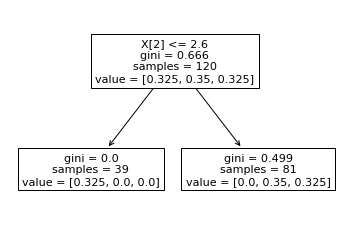

In [52]:
plot_tree(ada[0])

In [57]:
for name, val in zip(ada[0].tree_.feature, ada[0].tree_.threshold):
    print(f"{name:>40} -> {val}")

                                       2 -> 2.599999964237213
                                      -2 -> -2.0
                                      -2 -> -2.0


In [53]:
ada[0].tree_.value

array([[[0.325, 0.35 , 0.325]],

       [[0.325, 0.   , 0.   ]],

       [[0.   , 0.35 , 0.325]]])

[Text(167.4, 163.07999999999998, 'X[2] <= 4.75\ngini = 0.5\nsamples = 120\nvalue = [0.16, 0.173, 0.667]'),
 Text(83.7, 54.360000000000014, 'gini = 0.547\nsamples = 77\nvalue = [0.16, 0.152, 0.017]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.06\nsamples = 43\nvalue = [0.0, 0.021, 0.65]')]

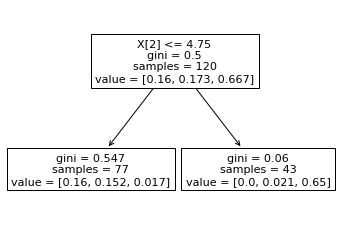

In [54]:
plot_tree(ada[1])

[Text(167.4, 163.07999999999998, 'X[3] <= 1.65\ngini = 0.52\nsamples = 120\nvalue = [0.066, 0.607, 0.327]'),
 Text(83.7, 54.360000000000014, 'gini = 0.234\nsamples = 82\nvalue = [0.066, 0.578, 0.021]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.158\nsamples = 38\nvalue = [0.0, 0.029, 0.306]')]

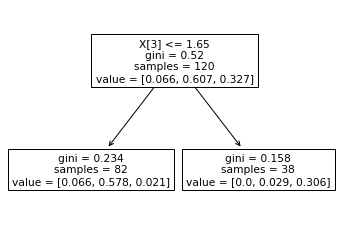

In [55]:
plot_tree(ada[2])

In [ ]:
# 1）首先计算第一个弱分类器权重，并更新样本权重。

# 初始化样本权重，每个样本的权重相同
w0 = np.full(shape = 120,fill_value=1/120)
# 计算弱分类器误差

y1 = ada[0].predict(X_train) # 第一个弱分类器的输出

e1 = ((y1 != y_train)*w0).sum()  # y1为弱分类器的预测值，y_train为真实值
# 计算弱分类器权重
a1 = np.round(learning_rate*(np.log((1-e1)/e1) + np.log(num - 1)),8)
# 更新样本权重
w1 = w0*np.exp(a1*(y_train != y1))
w1 /= w1.sum()

In [ ]:
# 2）计算第二个弱分类器权重，更新样本权重

# 计算弱分类器误差

y2 = ada[1].predict(X_train) # 第二个弱分类器的输出

e2 = ((y2 != y_train)*w1).sum()
# 计算弱分类器权重
a2 = np.round(learning_rate*(np.log((1-e2)/e2) + np.log(num - 1)),8)
# 更新样本权重
w2 = w1*np.exp(a2*(y_train != y2))
w2 /= w2.sum()

In [ ]:
# 3）计算第三个弱分类器权重，更新样本权重

# 计算弱分类器误差

y3 = ada[2].predict(X_train) # 第三个弱分类器的输出

e3 = ((y3 != y_train)*w2).sum()
# 计算弱分类器权重
a3 = np.round(learning_rate*(np.log((1-e3)/e3) + np.log(num - 1)),8)
# 更新样本权重
w3 = w2*np.exp(a3*(y_train != y3))
w3 /= w3.sum()

In [ ]:
e1,e2,e3

In [ ]:
y_predict= ada[2].predict(X_test)

print(y_predict)
print(np.shape(y_predict))

In [ ]:
np.array([[0],[1],[2]])

In [ ]:
# 4）将 预测向量 扩展为 one-hot 

y_predict_one_hot= (ada[0].predict(X_test) == np.array([[0],[1],[2]])).T.astype(np.int8)

print(y_predict_one_hot)
print(np.shape(y_predict_one_hot))

In [ ]:
# 5） 由3个弱分类器组合成强分类器。

# 第一个弱分类器的预测结果
y1_ = (ada[0].predict(X_test) == np.array([[0],[1],[2]])).T.astype(np.int8)
# 第二个弱分类器的预测结果
y2_ = (ada[1].predict(X_test) == np.array([[0],[1],[2]])).T.astype(np.int8)
# 第三个弱分类器的预测结果
y3_ = (ada[2].predict(X_test) == np.array([[0],[1],[2]])).T.astype(np.int8)

F = y1_*a1 + y2_*a2 + y3_*a3 # 强分类器

In [ ]:
print(F)
print(np.shape(F))

In [ ]:
estimator_weights = np.array([a1, a2, a3])
F /= estimator_weights.sum() 
F /= (num -1)
F

In [ ]:
(np.e**F).sum(axis = 1).reshape(-1,1)

In [ ]:
np.e**F / ((np.e**F).sum(axis = 1).reshape(-1,1))

In [ ]:
# 6）softmax处理，将结果转化为概率，使得大的值变的更大，小的值变得更小

pred = np.e**F / ((np.e**F).sum(axis = 1).reshape(-1,1))

In [ ]:
pred

In [ ]:
# 7） 取 概率最大的 作为 预测的标签 

pred = np.argmax(pred, axis=1)

In [ ]:
pred

In [ ]:
ada.predict(X_test)

### 实现 AdaBoost 的多分类

In [6]:
import sys 

sys.path.append('E:\\python package\\python-project\\统计学习方法\\Statistical-Learning-Method_Code-master\\DecisionTree')

In [7]:


from CartTree_classification_xrh import *


class AdaBoost_SAMME:
    """

    SAMME 算法 实现 AdaBoost 的多分类

    基分类器为 CART分类树

    Author: xrh
    Date: 2021-03-30

    ref:

    test1: 多分类任务

    数据集：Mnist
    参数: n_estimators=20,learning_rate=0.8
    训练集数量：60000
    测试集数量：10000
    正确率：0.8577
    模型训练时长：1099s

    """

    def __init__(self, error_rate_threshold=0.05, n_estimators=10, learning_rate=1.0, algorithm='SAMME',max_depth=5):
        """

        :param error_rate_threshold:
        :param n_estimators:
        :param learning_rate:
        :param algorithm:
        :param max_depth:

        """

        # 训练中止条件 error_rate <self.error_rate_threshold ( 若当前得到的基分类器的组合 错误率 小于阈值, 则停止训练)
        self.error_rate_threshold = error_rate_threshold

        # 弱分类器的个数 即 最大迭代次数
        self.n_estimators = n_estimators

        self.learning_rate = learning_rate  # 学习率

        self.algorithm = algorithm

        self.max_depth=max_depth # 基分类器(决策树)的最大深度

        self.G = []  # 弱分类器(决策树) 的集合


    def fit(self, X, y):
        """
        对训练数据进行学习

        :param X:
        :param y:
        :return:
        """

        N = np.shape(X)[0]

        self.K = len({ele for ele in y})  # y 中有多少种不同的标签,  K分类

        print('according to the training dataset : K={} classification task'.format(self.K))

        # 初始化样本权重w
        w = np.full(shape=N,fill_value=1/N )
        # w = np.ones((N)) * (1 / N)

        F = 0  # 强分类器

        feature_value_set = CartTree.get_feature_value_set(X) # 可供选择的特征集合 , 包括 (特征, 切分值)

        for m in range(self.n_estimators):  # 进行 第 m 轮迭代

            print('round:{}'.format(m))

            # 使用 自己 的 CartTree
            CT = CartTree(max_depth=self.max_depth)  # 第 m 个弱分类器
            CT.fit(X, y, feature_value_set=feature_value_set, sample_weight=w)

            # 使用 sklearn 的 CartTree
            # CT = DecisionTreeClassifier(max_depth=self.max_depth)
            # CT.fit(X, y,sample_weight=w)

            y_predict = CT.predict(X)

            em = ((y_predict != y) * w).sum()  # 计算弱分类器误差

            print('em:',em)

            alpha = self.learning_rate * ( np.log((1 - em) / em) + np.log(self.K - 1) )  # 弱分类器权重

            self.G.append( ( alpha, CT ) )  # 存储 基分类器

            # 当前 所有弱分类器加权 得到的 最终分类器 的 分类错误率

            y_predict_one_hot = (y_predict == np.array(range(self.K)).reshape(-1, 1)).T.astype(
                np.int8)  # 将 预测向量 扩展为 one-hot

            F += alpha * y_predict_one_hot  # 弱分类器组合成强分类器

            G = np.e ** F / ((np.e ** F).sum(axis=1).reshape(-1, 1))  # softmax处理，将结果转化为概率

            G_label = np.argmax(G, axis=1)  # 取 概率最大的 作为 预测的标签

            err_arr = np.ones(N, dtype=int)
            err_arr[G_label == y] = 0
            err_rate = np.mean(err_arr)  # 计算训练误差

            print('alpha:{}, err_rate:{}'.format(alpha, err_rate))

            if err_rate < self.error_rate_threshold:  # 错误率 已经小于 阈值, 则停止训练
                break

            # 更新 w
            w = w * np.exp( alpha * (y_predict != y) )
            w /= np.sum(w)

            print('w[0:10]:',w[0:10])

    def predict(self, X):

        """
        对新数据进行预测

        :param X:
        :return:
        """

        F = 0  # 最终分类器

        for alpha,CT in self.G:

            y_predict = CT.predict(X)

            y_predict_one_hot = (y_predict == np.array(range(self.K)).reshape(-1, 1)).T.astype(
                np.int8)  # 将 预测向量 扩展为 one-hot

            F += alpha * y_predict_one_hot  # 弱分类器组合成强分类器

        G = np.e ** F / ((np.e ** F).sum(axis=1).reshape(-1, 1))  # softmax处理，将结果转化为概率

        G_label = np.argmax(G, axis=1)  # 取 概率最大的 作为 预测的标签

        return G_label

    def score(self, X, y):
        """
        对训练效果进行评价
        :param X:
        :param y:
        :return:
        """
        G_label = self.predict(X)

        N = np.shape(X)[0]  # 样本的个数

        err_arr = np.ones(N, dtype=int)
        err_arr[G_label == y] = 0
        err_rate = np.mean(err_arr)

        accuracy = 1 - err_rate

        return accuracy

In [8]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

# 使用iris数据集，其中有三个分类， y的取值为0,1，2
X, y = datasets.load_iris(True)  # 包括150行记录
# 将数据集一分为二，训练数据占80%，测试数据占20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1024)


clf = AdaBoost_SAMME(n_estimators=3, learning_rate=0.8, max_depth=1)
clf.fit(X_train, y_train)

print(clf.score(X_test,y_test))

according to the training dataset : K=3 classification task
round:0
T.feature:None,T.feature_value:None, T.gini:0.0 , T.sample_N:39 , T.value:dict_items([(0, 0.3250000000000002)]) 
T.prev_feature:2,T.prev_feature_value: <= 1.9 
T.childs:None
Tree depth:1
T.label:0
-----------
T.feature:None,T.feature_value:None, T.gini:0.49931412894375815 , T.sample_N:81 , T.value:dict_items([(1, 0.35000000000000026), (2, 0.3250000000000002)]) 
T.prev_feature:2,T.prev_feature_value: > 1.9 
T.childs:None
Tree depth:1
T.label:1
-----------
T.feature:2,T.feature_value:1.9, T.gini:0.6662499999999996 , T.sample_N:120 , T.value:dict_items([(1, 0.35000000000000026), (2, 0.3250000000000002), (0, 0.3250000000000002)]) 
T.prev_feature:None,T.prev_feature_value:None 
T.childs:{0: <CartTree_classification_xrh.Node object at 0x000001F958347E80>, 1: <CartTree_classification_xrh.Node object at 0x000001F95978F518>}
Tree depth:0
T.label:None
-----------
em: 0.32499999999999996
alpha:1.1392277512821902, err_rate:0.325
w

In [5]:
np.shape(X)

(506, 13)